In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

DATA_PATH = r"D:\UWE CLASS\CSCT master\Master_project\Data\region_year_co2e.csv"
co2e = pd.read_csv(DATA_PATH)

OUT_DIR = r"D:\UWE CLASS\CSCT master\Master_project\Outputs\Prophet"
os.makedirs(OUT_DIR, exist_ok=True)

print("Saved outputs to:", OUT_DIR)
co2e.head()


Saved outputs to: D:\UWE CLASS\CSCT master\Master_project\Outputs\Prophet


,region_name,year,co2e_tonnes_total
0,East Midlands,2015,9.237719e+06
1,East Midlands,2016,9.515900e+06
2,East Midlands,2017,9.671759e+06
3,East Midlands,2018,9.750602e+06
4,East Midlands,2019,9.921433e+06


In [2]:
import sys

!{sys.executable} -m pip install prophet


   ---------------------------------------- 0.0/12.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/12.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/12.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/12.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/12.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/12.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/12.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/12.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/12.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/12.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/12.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/12.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/12.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/12.1 MB ? eta -:--:--
   -----------------

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
from prophet import Prophet
print("Prophet imported OK")


c:\Users\thana\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


Prophet imported OK


In [4]:
uk = co2e.groupby("year", as_index=False)["co2e_tonnes_total"].sum().sort_values("year")

df_uk = uk.copy()
df_uk["ds"] = pd.to_datetime(df_uk["year"].astype(int).astype(str) + "-01-01")
df_uk["y"]  = df_uk["co2e_tonnes_total"]

# COVID dummy (ปี 2020)
df_uk["covid"] = (df_uk["year"] == 2020).astype(int)

df_uk[["ds","y","covid"]].head()


,ds,y,covid
0,2015-01-01,1.037690e+08,0
1,2016-01-01,1.060252e+08,0
2,2017-01-01,1.074507e+08,0
3,2018-01-01,1.079359e+08,0
4,2019-01-01,1.091377e+08,0


In [5]:
train_end = 2022
train_uk = df_uk[df_uk["year"] <= train_end].copy()
test_uk  = df_uk[df_uk["year"] >  train_end].copy()

train_uk.shape, test_uk.shape


((8, 5), (2, 5))

In [6]:
def mae(y_true, y_pred):
    y_true = np.asarray(y_true); y_pred = np.asarray(y_pred)
    return np.mean(np.abs(y_true - y_pred))

def rmse(y_true, y_pred):
    y_true = np.asarray(y_true); y_pred = np.asarray(y_pred)
    return np.sqrt(np.mean((y_true - y_pred)**2))

def mape(y_true, y_pred):
    y_true = np.asarray(y_true); y_pred = np.asarray(y_pred)
    return np.mean(np.abs((y_true - y_pred) / (y_true + 1e-9))) * 100


In [7]:
from prophet import Prophet

m_uk = Prophet(
    growth="linear",
    yearly_seasonality=False,
    weekly_seasonality=False,
    daily_seasonality=False,
    changepoint_prior_scale=0.3,   # ลอง 0.05, 0.1, 0.3, 0.5 ได้
    seasonality_mode="additive"
)

m_uk.add_regressor("covid")

m_uk.fit(train_uk[["ds","y","covid"]])


23:21:33 - cmdstanpy - INFO - Chain [1] start processing
23:21:33 - cmdstanpy - INFO - Chain [1] done processing


In [8]:
future_test = test_uk[["ds","covid"]].copy()
fc_test = m_uk.predict(future_test)

y_true = test_uk["y"].values
y_pred = fc_test["yhat"].values

uk_metrics = pd.DataFrame([{
    "series":"UK",
    "model":"Prophet",
    "MAE": mae(y_true, y_pred),
    "RMSE": rmse(y_true, y_pred),
    "MAPE(%)": mape(y_true, y_pred)
}])

uk_metrics


,series,model,MAE,RMSE,MAPE(%)
0,UK,Prophet,7.870615e+06,7.998864e+06,7.320887


In [9]:
naive_pred = np.full(len(test_uk), train_uk["y"].iloc[-1])

baseline = pd.DataFrame([{
    "series":"UK",
    "model":"Naive",
    "MAE": mae(y_true, naive_pred),
    "RMSE": rmse(y_true, naive_pred),
    "MAPE(%)": mape(y_true, naive_pred)
}])

pd.concat([baseline, uk_metrics], ignore_index=True).sort_values("RMSE")


,series,model,MAE,RMSE,MAPE(%)
0,UK,Naive,2.160283e+06,2.244996e+06,2.008235
1,UK,Prophet,7.870615e+06,7.998864e+06,7.320887


In [10]:
m_uk_full = Prophet(
    growth="linear",
    yearly_seasonality=False,
    weekly_seasonality=False,
    daily_seasonality=False,
    changepoint_prior_scale=0.3,
    seasonality_mode="additive"
)
m_uk_full.add_regressor("covid")
m_uk_full.fit(df_uk[["ds","y","covid"]])

future_years = np.arange(df_uk["year"].max()+1, 2031)  # 2025–2030
future = pd.DataFrame({
    "ds": pd.to_datetime(future_years.astype(int).astype(str) + "-01-01"),
    "covid": 0
})
fc_future = m_uk_full.predict(future)

uk_forecast = pd.DataFrame({
    "year": future_years,
    "yhat": fc_future["yhat"].values,
    "yhat_lower": fc_future["yhat_lower"].values,
    "yhat_upper": fc_future["yhat_upper"].values
})
uk_forecast.head()


23:22:43 - cmdstanpy - INFO - Chain [1] start processing
23:22:43 - cmdstanpy - INFO - Chain [1] done processing


,year,yhat,yhat_lower,yhat_upper
0,2025,1.094576e+08,1.066648e+08,1.122898e+08
1,2026,1.108439e+08,1.018556e+08,1.200961e+08
2,2027,1.122302e+08,9.437242e+07,1.304297e+08
3,2028,1.136164e+08,8.460914e+07,1.417005e+08
4,2029,1.150065e+08,7.428016e+07,1.547009e+08


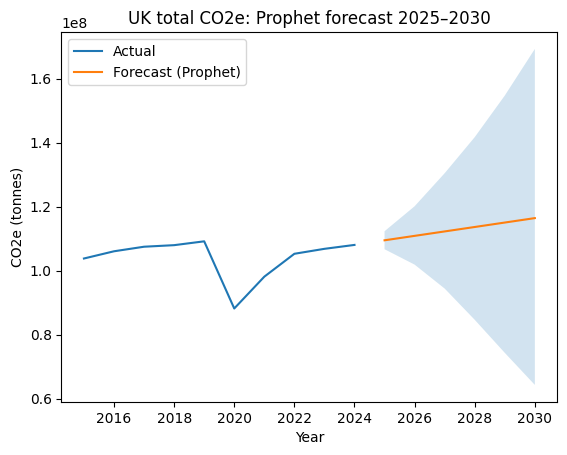

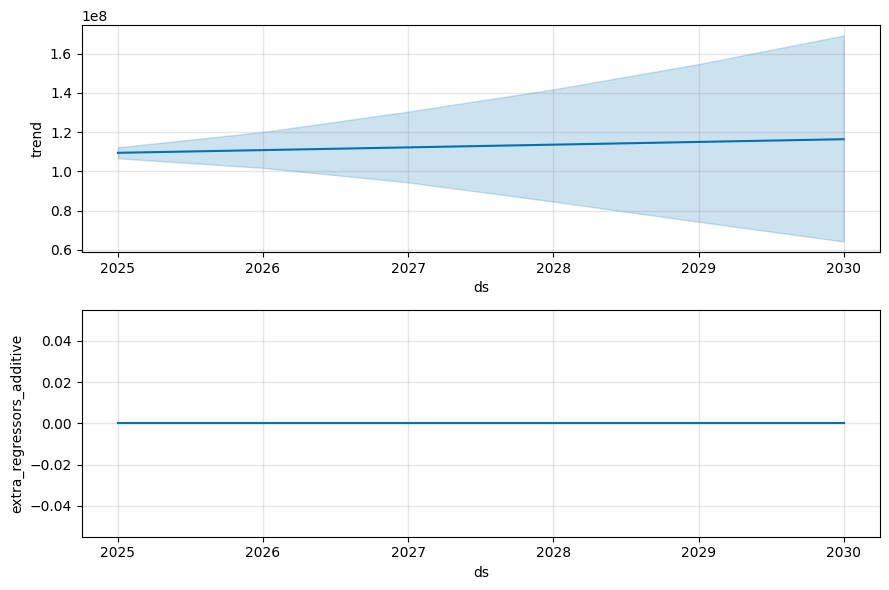

In [12]:
plt.figure()
plt.plot(df_uk["year"], df_uk["y"], label="Actual")
plt.plot(uk_forecast["year"], uk_forecast["yhat"], label="Forecast (Prophet)")
plt.fill_between(uk_forecast["year"], uk_forecast["yhat_lower"], uk_forecast["yhat_upper"], alpha=0.2)
plt.xlabel("Year")
plt.ylabel("CO2e (tonnes)")
plt.title("UK total CO2e: Prophet forecast 2025–2030")
plt.legend()
plt.savefig(os.path.join(OUT_DIR, "uk_prophet_forecast_2025_2030.png"), dpi=300, bbox_inches="tight")
plt.show()

uk_forecast.to_csv(os.path.join(OUT_DIR, "uk_prophet_forecast_2025_2030.csv"), index=False)

fig = m_uk_full.plot_components(fc_future)
fig.savefig(os.path.join(OUT_DIR, "uk_prophet_components.png"), dpi=300, bbox_inches="tight")



In [13]:
latest = co2e["year"].max()
top5_regions = (co2e[co2e["year"]==latest]
                .sort_values("co2e_tonnes_total", ascending=False)
                .head(5)["region_name"].tolist())
top5_regions


['South East', 'East of England', 'North West', 'South West', 'West Midlands']

In [14]:
from prophet import Prophet

def prophet_region_pipeline(region_name, df_all, train_end=2022, cps=0.3):
    ts = df_all[df_all["region_name"]==region_name].sort_values("year").copy()
    ts["ds"] = pd.to_datetime(ts["year"].astype(int).astype(str) + "-01-01")
    ts["y"]  = ts["co2e_tonnes_total"]
    ts["covid"] = (ts["year"]==2020).astype(int)

    train = ts[ts["year"]<=train_end].copy()
    test  = ts[ts["year"]> train_end].copy()

    m = Prophet(
        growth="linear",
        yearly_seasonality=False,
        weekly_seasonality=False,
        daily_seasonality=False,
        changepoint_prior_scale=cps,
        seasonality_mode="additive"
    )
    m.add_regressor("covid")
    m.fit(train[["ds","y","covid"]])

    # test prediction
    fc_test = m.predict(test[["ds","covid"]])
    y_true = test["y"].values
    y_pred = fc_test["yhat"].values

    met_prophet = {
        "region_name": region_name,
        "model": "Prophet",
        "MAE": mae(y_true, y_pred),
        "RMSE": rmse(y_true, y_pred),
        "MAPE(%)": mape(y_true, y_pred)
    }

    # naive baseline
    naive_pred = np.full(len(test), train["y"].iloc[-1])
    met_naive = {
        "region_name": region_name,
        "model": "Naive",
        "MAE": mae(y_true, naive_pred),
        "RMSE": rmse(y_true, naive_pred),
        "MAPE(%)": mape(y_true, naive_pred)
    }

    # fit full + future forecast
    m_full = Prophet(
        growth="linear",
        yearly_seasonality=False,
        weekly_seasonality=False,
        daily_seasonality=False,
        changepoint_prior_scale=cps,
        seasonality_mode="additive"
    )
    m_full.add_regressor("covid")
    m_full.fit(ts[["ds","y","covid"]])

    future_years = np.arange(ts["year"].max()+1, 2031)
    future = pd.DataFrame({
        "ds": pd.to_datetime(future_years.astype(int).astype(str) + "-01-01"),
        "covid": 0
    })
    fc_future = m_full.predict(future)

    forecast = pd.DataFrame({
        "region_name": region_name,
        "year": future_years,
        "yhat": fc_future["yhat"].values,
        "yhat_lower": fc_future["yhat_lower"].values,
        "yhat_upper": fc_future["yhat_upper"].values,
        "changepoint_prior_scale": cps
    })

    return ts, met_naive, met_prophet, forecast, m_full


In [15]:
metrics_list = []
forecast_list = []

# สร้าง df_all แบบมี year/region/value
df_all = co2e.copy()

models_store = {}  # เก็บ model ไว้ plot components ได้

for r in top5_regions:
    ts, met_naive, met_prophet, fc, m_full = prophet_region_pipeline(r, df_all, train_end=2022, cps=0.3)
    metrics_list += [met_naive, met_prophet]
    forecast_list.append(fc)
    models_store[r] = m_full

metrics_regions = pd.DataFrame(metrics_list).sort_values(["region_name","RMSE"])
forecasts_regions = pd.concat(forecast_list, ignore_index=True)

metrics_regions.to_csv(os.path.join(OUT_DIR, "top5_prophet_vs_naive_metrics.csv"), index=False)
forecasts_regions.to_csv(os.path.join(OUT_DIR, "top5_prophet_forecasts_2025_2030.csv"), index=False)

metrics_regions


23:23:35 - cmdstanpy - INFO - Chain [1] start processing
23:23:35 - cmdstanpy - INFO - Chain [1] done processing
23:23:35 - cmdstanpy - INFO - Chain [1] start processing
23:23:35 - cmdstanpy - INFO - Chain [1] done processing
23:23:35 - cmdstanpy - INFO - Chain [1] start processing
23:23:35 - cmdstanpy - INFO - Chain [1] done processing
23:23:35 - cmdstanpy - INFO - Chain [1] start processing
23:23:35 - cmdstanpy - INFO - Chain [1] done processing
23:23:36 - cmdstanpy - INFO - Chain [1] start processing
23:23:36 - cmdstanpy - INFO - Chain [1] done processing
23:23:36 - cmdstanpy - INFO - Chain [1] start processing
23:23:36 - cmdstanpy - INFO - Chain [1] done processing
23:23:36 - cmdstanpy - INFO - Chain [1] start processing
23:23:36 - cmdstanpy - INFO - Chain [1] done processing
23:23:36 - cmdstanpy - INFO - Chain [1] start processing
23:23:36 - cmdstanpy - INFO - Chain [1] done processing
23:23:36 - cmdstanpy - INFO - Chain [1] start processing
23:23:36 - cmdstanpy - INFO - Chain [1]

,region_name,model,MAE,RMSE,MAPE(%)
2,East of England,Naive,2.406664e+05,2.442091e+05,1.932630
3,East of England,Prophet,8.536461e+05,8.606712e+05,6.856055
4,North West,Naive,2.817270e+05,3.037664e+05,2.402975
5,North West,Prophet,8.456491e+05,8.676651e+05,7.225142
0,South East,Naive,3.512019e+05,3.595980e+05,2.086465
1,South East,Prophet,1.469459e+06,1.490254e+06,8.732004
6,South West,Naive,2.387963e+05,2.418724e+05,2.188740
7,South West,Prophet,6.556681e+05,7.052277e+05,6.004686
8,West Midlands,Naive,2.415720e+05,2.549368e+05,2.248407
9,West Midlands,Prophet,8.117293e+05,8.261545e+05,7.563601


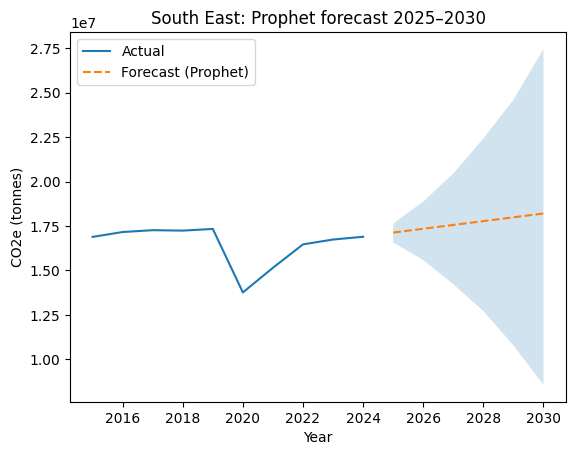

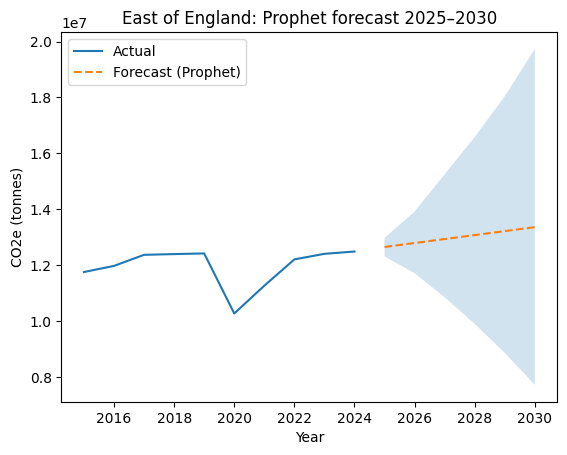

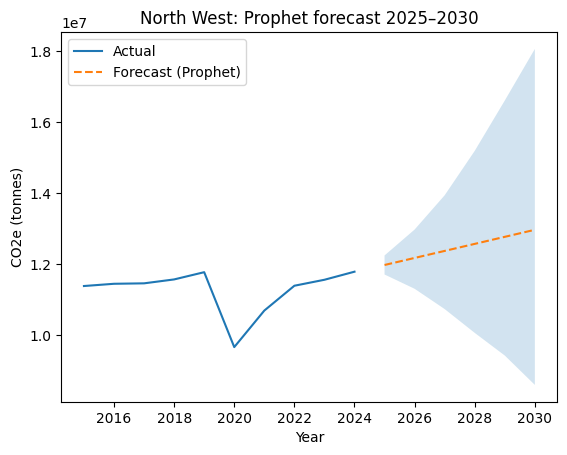

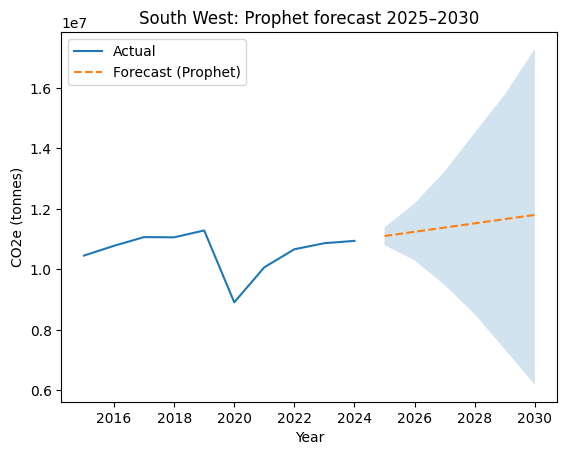

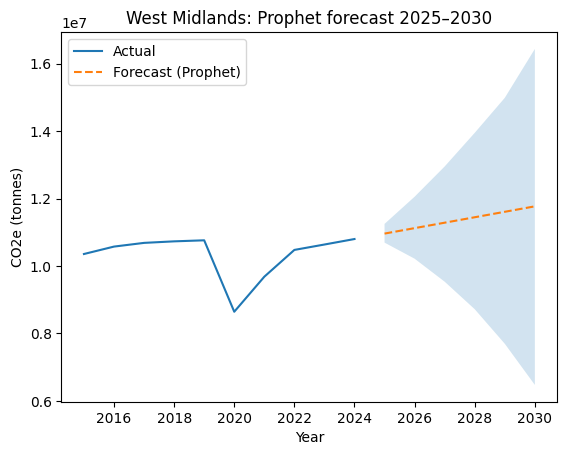

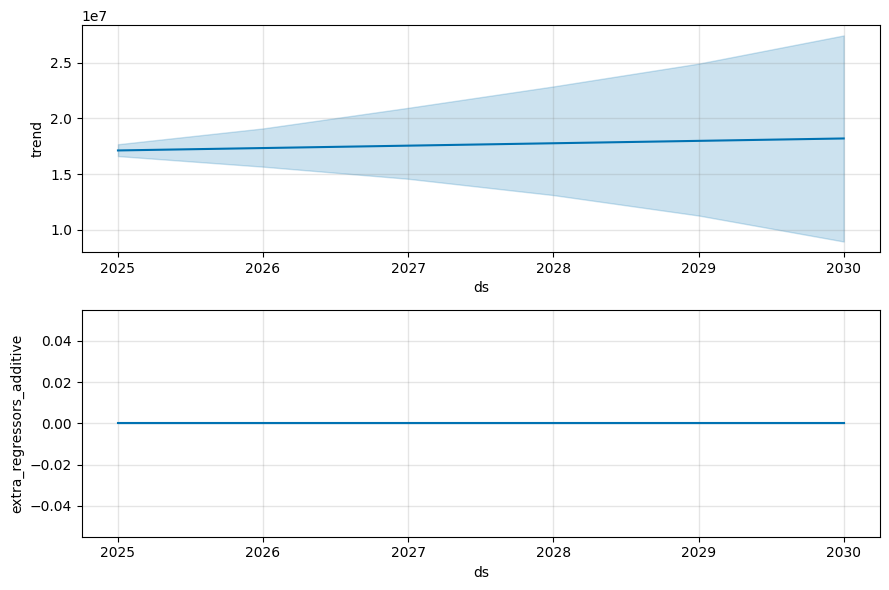

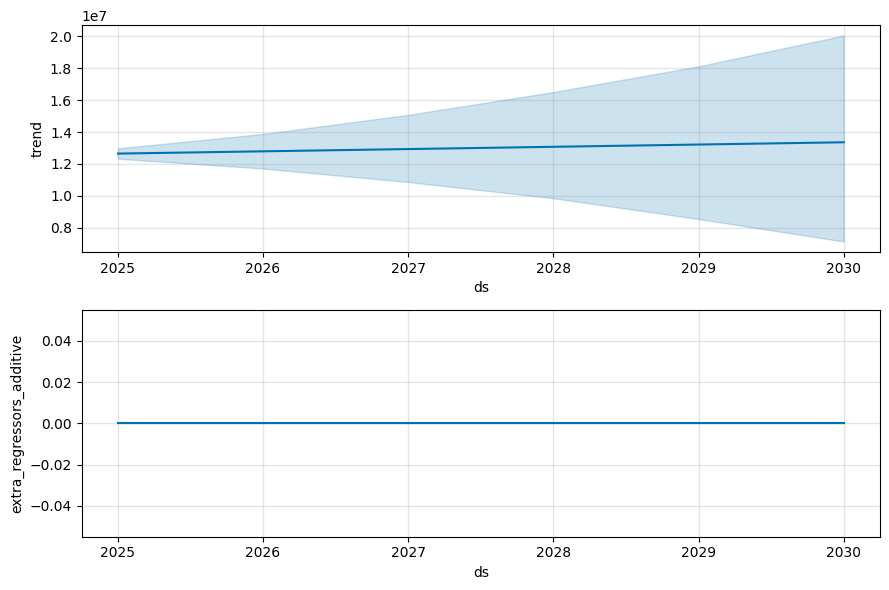

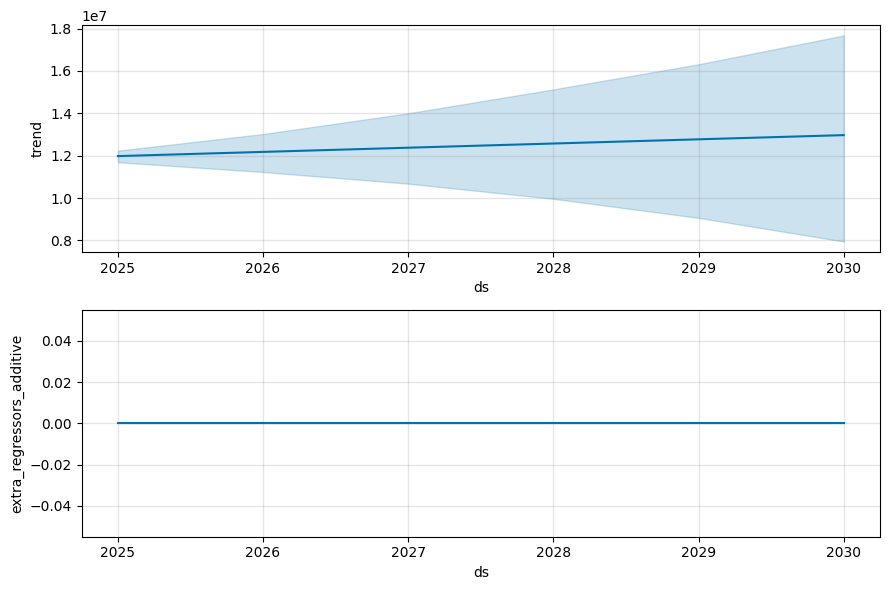

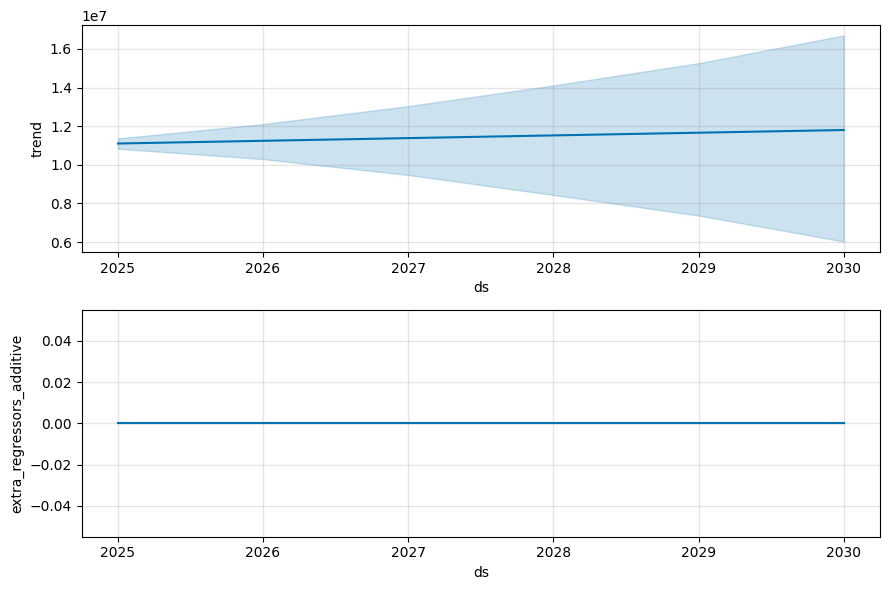

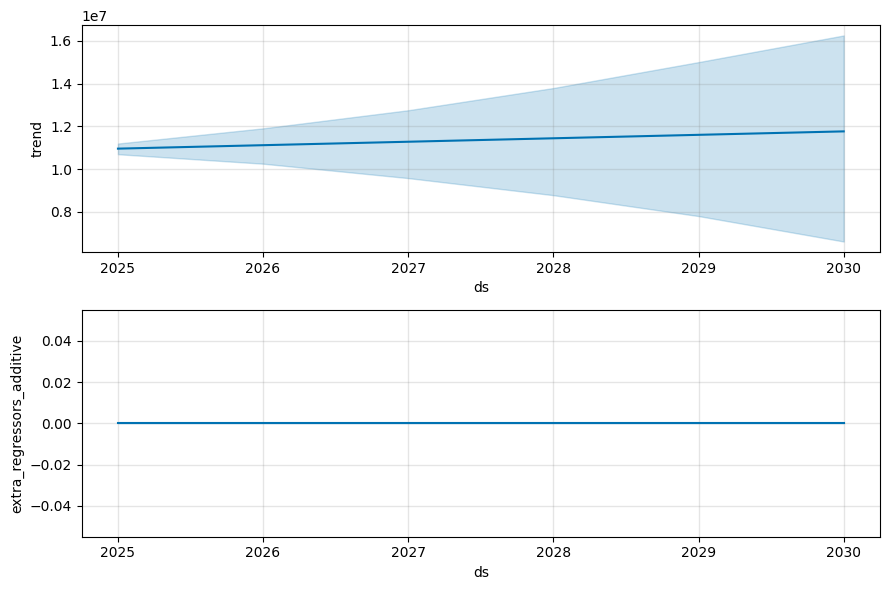

In [17]:
for r in top5_regions:
    hist = co2e[co2e["region_name"]==r].sort_values("year")
    fut  = forecasts_regions[forecasts_regions["region_name"]==r].sort_values("year")

    plt.figure()
    plt.plot(hist["year"], hist["co2e_tonnes_total"], label="Actual")
    plt.plot(fut["year"], fut["yhat"], linestyle="--", label="Forecast (Prophet)")
    plt.fill_between(fut["year"], fut["yhat_lower"], fut["yhat_upper"], alpha=0.2)

    plt.xlabel("Year")
    plt.ylabel("CO2e (tonnes)")
    plt.title(f"{r}: Prophet forecast 2025–2030")
    plt.legend()

    fname = f"prophet_forecast_{r.replace(' ','_')}_2025_2030.png"
    plt.savefig(os.path.join(OUT_DIR, fname), dpi=300, bbox_inches="tight")
    plt.show()
    
for r in top5_regions:
    fig = models_store[r].plot_components(models_store[r].predict(
        pd.DataFrame({
            "ds": pd.to_datetime(np.arange(2025, 2031).astype(str) + "-01-01"),
            "covid": 0
        })
    ))
    fig.savefig(os.path.join(OUT_DIR, f"{r.replace(' ','_')}_prophet_components.png"),
                dpi=300, bbox_inches="tight")
    


In [18]:
cps_grid = [0.05, 0.1, 0.3, 0.5]
rows = []

for cps in cps_grid:
    # UK tuning
    m = Prophet(yearly_seasonality=False, weekly_seasonality=False, daily_seasonality=False,
                changepoint_prior_scale=cps)
    m.add_regressor("covid")
    m.fit(train_uk[["ds","y","covid"]])
    fc = m.predict(test_uk[["ds","covid"]])
    rows.append(["UK", cps, rmse(test_uk["y"].values, fc["yhat"].values)])

tune_uk = pd.DataFrame(rows, columns=["series","changepoint_prior_scale","RMSE"]).sort_values("RMSE")
tune_uk.to_csv(os.path.join(OUT_DIR, "uk_prophet_cps_tuning.csv"), index=False)
tune_uk


23:24:39 - cmdstanpy - INFO - Chain [1] start processing
23:24:39 - cmdstanpy - INFO - Chain [1] done processing
23:24:39 - cmdstanpy - INFO - Chain [1] start processing
23:24:39 - cmdstanpy - INFO - Chain [1] done processing
23:24:40 - cmdstanpy - INFO - Chain [1] start processing
23:24:40 - cmdstanpy - INFO - Chain [1] done processing
23:24:40 - cmdstanpy - INFO - Chain [1] start processing
23:24:40 - cmdstanpy - INFO - Chain [1] done processing


,series,changepoint_prior_scale,RMSE
0,UK,0.05,4.408759e+06
1,UK,0.10,6.272553e+06
2,UK,0.30,7.998864e+06
3,UK,0.50,9.068803e+06
